# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product

import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob as glob
gsname = "gs0825"
L = []
for fp in glob('data/'+gsname+'/*'):
  df_ = pd.read_csv(fp)
  L.append(df_)
gsdf = pd.concat(L)
gsdf.to_csv('data/gsdf-'+gsname+'.csv')

In [3]:
gsdf.loc[:,'mi'] = gsdf.middle-gsdf.interleaved
gsdf.loc[:,'bi'] = gsdf.blocked-gsdf.interleaved
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi,bi
0,0,16.50,5000.0,10.00,0.80,2.0,1.0,1.0,1.0,1.00000,0.500000,1.00000,0.5000,0.5000,0.000000,0.500000
0,0,13.00,5000.0,11.00,0.80,2.0,1.0,1.0,1.0,1.00000,0.500000,1.00000,0.5000,0.5000,0.000000,0.500000
0,0,3.75,5000.0,8.00,1.16,2.0,1.0,1.0,1.0,0.50675,0.502750,0.50650,0.4910,0.5000,-0.011750,0.004000
1,1,3.75,5000.0,10.00,1.16,2.0,1.0,1.0,1.0,0.48625,0.496750,0.50225,0.5075,0.5090,0.010750,-0.010500
0,0,10.25,5000.0,6.00,0.80,2.0,1.0,1.0,1.0,1.00000,0.500000,1.00000,0.5000,0.5000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,11.50,5000.0,14.25,0.80,2.0,1.0,1.0,1.0,1.00000,0.510500,1.00000,0.4910,0.5015,-0.019500,0.489500
0,0,6.75,5000.0,8.00,0.36,2.0,1.0,1.0,1.0,1.00000,0.952377,1.00000,1.0000,1.0000,0.047623,0.047623
1,1,6.75,5000.0,10.00,0.36,2.0,1.0,1.0,1.0,1.00000,0.949164,1.00000,1.0000,1.0000,0.050836,0.050836
0,0,13.75,5000.0,8.50,0.80,2.0,1.0,1.0,1.0,1.00000,0.500000,1.00000,0.5000,0.5000,0.000000,0.500000


In [4]:
gsdf.concentration.max()

19.75

In [5]:
A = gsdf.blocked > 0.9
MI = gsdf.mi > 0.02
I = gsdf.interleaved < .65
df = gsdf[A&MI&I].sort_values('mi',ascending=False)
df

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi,bi
1,1,8.50,5000.0,10.00,0.785,2.0,1.0,1.0,1.0,1.000000,0.482776,1.000000,0.700982,0.561462,0.218205,0.517224
1,1,9.50,5000.0,10.00,1.060,2.0,1.0,1.0,1.0,1.000000,0.539815,1.000000,0.752346,0.685105,0.212531,0.460185
0,0,3.75,5000.0,8.00,0.260,2.0,1.0,1.0,1.0,1.000000,0.571000,1.000000,0.752250,0.592250,0.181250,0.429000
1,1,6.50,5000.0,10.00,0.460,2.0,1.0,1.0,1.0,1.000000,0.584896,1.000000,0.749500,0.649250,0.164604,0.415104
1,1,9.75,5000.0,10.00,1.160,2.0,1.0,1.0,1.0,1.000000,0.494969,1.000000,0.655376,0.606565,0.160407,0.505031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,20,2.01,5000.0,16.00,0.110,2.0,1.0,1.0,1.0,0.994250,0.491000,0.993375,0.511062,0.494375,0.020063,0.503250
23,23,2.31,5000.0,8.00,0.210,2.0,1.0,1.0,1.0,1.000000,0.501000,1.000000,0.521062,0.502000,0.020062,0.499000
0,0,9.00,5000.0,13.25,0.800,2.0,1.0,1.0,1.0,1.000000,0.485718,1.000000,0.505750,0.498197,0.020032,0.514282
0,0,10.25,5000.0,14.75,0.800,2.0,1.0,1.0,1.0,1.000000,0.500737,1.000000,0.520750,0.497941,0.020013,0.499263


Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

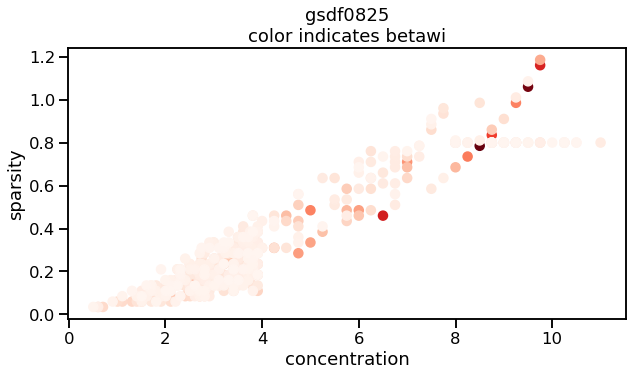

In [6]:
f,ax=plt.subplots(1,1,figsize=(10,5))
# df = gsdf
X = gsdf.stickiness_bt>6
df = gsdf[A&MI&I&X].sort_values('mi',ascending=False)

ax.scatter(df.concentration,df.sparsity,c=df.mi,cmap='Reds')
ax.set_xlabel('concentration')
ax.set_ylabel('sparsity')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

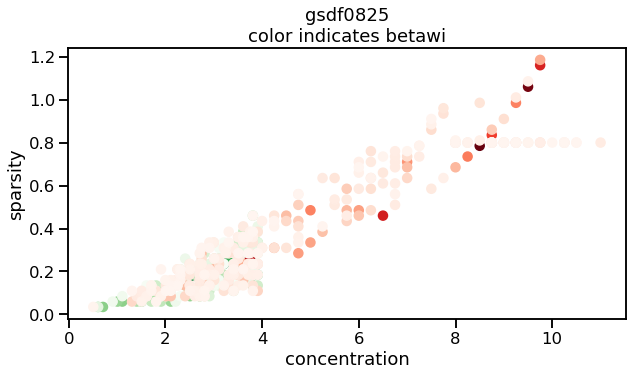

In [7]:
f,ax=plt.subplots(1,1,figsize=(10,5))
# df = gsdf
cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.sparsity,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('sparsity')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

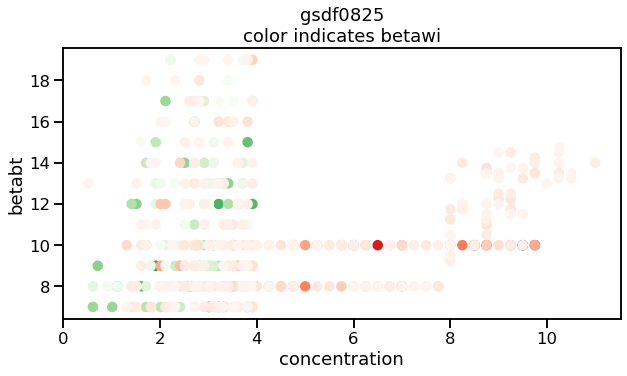

In [8]:
f,ax=plt.subplots(1,1,figsize=(10,5))

cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.stickiness_bt,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('betabt')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')